## Setup & Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## Load Data

Load hasil aggregasi dari `processed/train_processed.csv`.

In [2]:
# Load the aggregated data
train_merged = pd.read_csv('/content/processed/train_processed.csv')

print(f"Data shape: {train_merged.shape}")
print(f"\nTarget distribution:")
print(train_merged['TARGET'].value_counts())
print(f"\nTarget distribution (percentage):")
print(train_merged['TARGET'].value_counts(normalize=True))

train_merged.head()

Data shape: (307511, 149)

Target distribution:
TARGET
0    282686
1     24825
Name: count, dtype: int64

Target distribution (percentage):
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BU_DAYS_CREDIT_mean,BU_DAYS_CREDIT_min,BU_DAYS_CREDIT_max,BU_AMT_CREDIT_SUM_sum,BU_AMT_CREDIT_SUM_mean,BU_AMT_CREDIT_SUM_max,BU_AMT_CREDIT_SUM_DEBT_sum,BU_AMT_CREDIT_SUM_DEBT_mean,BU_CREDIT_DAY_OVERDUE_sum,BU_CREDIT_DAY_OVERDUE_max,BU_CREDIT_ACTIVE_<lambda>,PA_AMT_CREDIT_mean,PA_AMT_CREDIT_max,PA_AMT_CREDIT_min,PA_AMT_CREDIT_sum,PA_AMT_ANNUITY_mean,PA_AMT_ANNUITY_max,PA_AMT_ANNUITY_min,PA_AMT_ANNUITY_sum,PA_AMT_GOODS_PRICE_mean,PA_AMT_GOODS_PRICE_max,PA_AMT_GOODS_PRICE_min,PA_AMT_GOODS_PRICE_sum,PA_DAYS_DECISION_mean,PA_DAYS_DECISION_max,PA_DAYS_DECISION_min,PA_DAYS_DECISION_sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,-874.00,-1437.0,-103.0,865055.565,108131.945625,450000.0,245781.0,49156.2,0.0,0.0,Closed,179055.00,179055.0,179055.0,179055.0,9251.775,9251.775,9251.775,9251.775,179055.00,179055.0,179055.00,179055.00,-606.000000,-606.0,-606.0,-606.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.

## 1. Dynamic Feature Engineering

Feature engineering tambahan untuk meningkatkan performa model dengan membuat fitur-fitur baru yang relevan untuk credit risk scoring.

In [3]:
# Make a copy for preprocessing
df = train_merged.copy()

# Advanced Feature Engineering for Credit Risk
# 1. Credit utilization ratio
if 'AMT_CREDIT' in df.columns and 'AMT_ANNUITY' in df.columns:
    df['CREDIT_ANNUITY_RATIO'] = df['AMT_CREDIT'] / (df['AMT_ANNUITY'] + 1)
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / (df['AMT_CREDIT'] + 1)

# 2. Income ratios
if 'AMT_INCOME_TOTAL' in df.columns and 'AMT_CREDIT' in df.columns:
    df['INCOME_CREDIT_RATIO'] = df['AMT_INCOME_TOTAL'] / (df['AMT_CREDIT'] + 1)
    df['CREDIT_INCOME_RATIO'] = df['AMT_CREDIT'] / (df['AMT_INCOME_TOTAL'] + 1)

# 3. Annuity burden
if 'AMT_ANNUITY' in df.columns and 'AMT_INCOME_TOTAL' in df.columns:
    df['ANNUITY_INCOME_RATIO'] = df['AMT_ANNUITY'] / (df['AMT_INCOME_TOTAL'] + 1)
    # Debt burden indicator
    df['HIGH_DEBT_BURDEN'] = (df['ANNUITY_INCOME_RATIO'] > 0.35).astype(int)

# 4. Credit to goods price analysis
if 'AMT_CREDIT' in df.columns and 'AMT_GOODS_PRICE' in df.columns:
    df['CREDIT_GOODS_RATIO'] = df['AMT_CREDIT'] / (df['AMT_GOODS_PRICE'] + 1)
    df['CREDIT_GOODS_DIFF'] = df['AMT_CREDIT'] - df['AMT_GOODS_PRICE']
    df['OVERPRICE_RATIO'] = (df['AMT_CREDIT'] - df['AMT_GOODS_PRICE']) / (df['AMT_GOODS_PRICE'] + 1)

# 5. Employment stability features
if 'DAYS_EMPLOYED' in df.columns and 'DAYS_BIRTH' in df.columns:
    df['EMPLOYED_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / (df['DAYS_BIRTH'] + 1)
    # Convert to positive years
    df['YEARS_EMPLOYED'] = df['DAYS_EMPLOYED'] / -365
    df['AGE_YEARS'] = df['DAYS_BIRTH'] / -365
    df['EMPLOYMENT_LENGTH_RATIO'] = df['YEARS_EMPLOYED'] / (df['AGE_YEARS'] + 1)

# 6. Enhanced external source features
ext_sources = [col for col in df.columns if 'EXT_SOURCE' in col]
if len(ext_sources) > 0:
    df['EXT_SOURCE_MEAN'] = df[ext_sources].mean(axis=1)
    df['EXT_SOURCE_MAX'] = df[ext_sources].max(axis=1)
    df['EXT_SOURCE_MIN'] = df[ext_sources].min(axis=1)
    df['EXT_SOURCE_STD'] = df[ext_sources].std(axis=1)
    df['EXT_SOURCE_MEDIAN'] = df[ext_sources].median(axis=1)
    # Weighted combination (weights based on typical importance)
    if 'EXT_SOURCE_1' in ext_sources and 'EXT_SOURCE_2' in ext_sources and 'EXT_SOURCE_3' in ext_sources:
        df['EXT_SOURCE_WEIGHTED'] = (0.3 * df['EXT_SOURCE_1'].fillna(0) +
                                     0.4 * df['EXT_SOURCE_2'].fillna(0) +
                                     0.3 * df['EXT_SOURCE_3'].fillna(0))

# 7. Phone and registration features
if 'DAYS_LAST_PHONE_CHANGE' in df.columns and 'DAYS_BIRTH' in df.columns:
    df['PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / (df['DAYS_BIRTH'] + 1)
    df['PHONE_CHANGE_YEARS'] = df['DAYS_LAST_PHONE_CHANGE'] / -365

if 'DAYS_REGISTRATION' in df.columns:
    df['REGISTRATION_YEARS'] = df['DAYS_REGISTRATION'] / -365

# 8. Family and social features
if 'AMT_INCOME_TOTAL' in df.columns and 'CNT_FAM_MEMBERS' in df.columns:
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / (df['CNT_FAM_MEMBERS'] + 1)

if 'CNT_CHILDREN' in df.columns and 'CNT_FAM_MEMBERS' in df.columns:
    df['CHILDREN_RATIO'] = df['CNT_CHILDREN'] / (df['CNT_FAM_MEMBERS'] + 1)

# 9. Document completeness score
doc_cols = [col for col in df.columns if 'FLAG_DOCUMENT' in col]
if len(doc_cols) > 0:
    df['DOCUMENT_COMPLETENESS'] = df[doc_cols].sum(axis=1)

# 10. Credit bureau activity
if 'AMT_REQ_CREDIT_BUREAU_YEAR' in df.columns:
    bureau_cols = [col for col in df.columns if 'AMT_REQ_CREDIT_BUREAU' in col]
    if len(bureau_cols) > 0:
        df['CREDIT_BUREAU_TOTAL'] = df[bureau_cols].sum(axis=1)
        df['CREDIT_BUREAU_ACTIVITY'] = (df['CREDIT_BUREAU_TOTAL'] > 2).astype(int)

print(f"Original features: {train_merged.shape[1]}")
print(f"After feature engineering: {df.shape[1]}")
print(f"New features added: {df.shape[1] - train_merged.shape[1]}")

# Show new features
new_features = [col for col in df.columns if col not in train_merged.columns]
print(f"\nNew features: {new_features}")

Original features: 149
After feature engineering: 176
New features added: 27

New features: ['CREDIT_ANNUITY_RATIO', 'PAYMENT_RATE', 'INCOME_CREDIT_RATIO', 'CREDIT_INCOME_RATIO', 'ANNUITY_INCOME_RATIO', 'HIGH_DEBT_BURDEN', 'CREDIT_GOODS_RATIO', 'CREDIT_GOODS_DIFF', 'OVERPRICE_RATIO', 'EMPLOYED_TO_BIRTH_RATIO', 'YEARS_EMPLOYED', 'AGE_YEARS', 'EMPLOYMENT_LENGTH_RATIO', 'EXT_SOURCE_MEAN', 'EXT_SOURCE_MAX', 'EXT_SOURCE_MIN', 'EXT_SOURCE_STD', 'EXT_SOURCE_MEDIAN', 'EXT_SOURCE_WEIGHTED', 'PHONE_TO_BIRTH_RATIO', 'PHONE_CHANGE_YEARS', 'REGISTRATION_YEARS', 'INCOME_PER_PERSON', 'CHILDREN_RATIO', 'DOCUMENT_COMPLETENESS', 'CREDIT_BUREAU_TOTAL', 'CREDIT_BUREAU_ACTIVITY']


## 2. Handling Missing Values

Strategi handling missing values:
- Drop kolom dengan missing > 50%
- Numeric features: impute dengan median
- Categorical features: impute dengan mode atau create 'Unknown' category

In [4]:
# Calculate missing percentage
missing_percentage = (df.isnull().sum() / len(df)) * 100

# Show missing value statistics
print("Missing Value Analysis:")
print(f"Total features: {len(missing_percentage)}")
print(f"Features with missing values: {(missing_percentage > 0).sum()}")
print(f"\nTop 20 features with highest missing percentage:")
print(missing_percentage.sort_values(ascending=False).head(20))

# Drop columns with more than 50% missing values (lebih agresif dari 70%)
threshold = 50
cols_to_drop = missing_percentage[missing_percentage > threshold].index.tolist()

print(f"\nDropping {len(cols_to_drop)} columns with > {threshold}% missing values")
if len(cols_to_drop) > 0:
    print(f"Columns to drop: {cols_to_drop[:10]}...")  # Show first 10
    df = df.drop(columns=cols_to_drop)
else:
    print("No columns to drop based on threshold")

print(f"\nShape after dropping high missing columns: {df.shape}")

Missing Value Analysis:
Total features: 176
Features with missing values: 109

Top 20 features with highest missing percentage:
COMMONAREA_MODE             69.872297
COMMONAREA_MEDI             69.872297
COMMONAREA_AVG              69.872297
NONLIVINGAPARTMENTS_AVG     69.432963
NONLIVINGAPARTMENTS_MEDI    69.432963
NONLIVINGAPARTMENTS_MODE    69.432963
FONDKAPREMONT_MODE          68.386172
LIVINGAPARTMENTS_MODE       68.354953
LIVINGAPARTMENTS_MEDI       68.354953
LIVINGAPARTMENTS_AVG        68.354953
FLOORSMIN_AVG               67.848630
FLOORSMIN_MODE              67.848630
FLOORSMIN_MEDI              67.848630
YEARS_BUILD_AVG             66.497784
YEARS_BUILD_MODE            66.497784
YEARS_BUILD_MEDI            66.497784
OWN_CAR_AGE                 65.990810
LANDAREA_MODE               59.376738
LANDAREA_MEDI               59.376738
LANDAREA_AVG                59.376738
dtype: float64

Dropping 41 columns with > 50% missing values
Columns to drop: ['OWN_CAR_AGE', 'EXT_SOURCE_1', '

In [5]:
# Separate numeric and categorical columns
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# Remove TARGET from numeric features if exists
if 'TARGET' in numeric_features:
    numeric_features.remove('TARGET')

# Remove ID columns
id_cols = ['SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV']
for id_col in id_cols:
    if id_col in numeric_features:
        numeric_features.remove(id_col)
    if id_col in categorical_features:
        categorical_features.remove(id_col)

print(f"Numeric features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")

# Impute missing values
# Numeric: fill with median
for col in numeric_features:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

# Categorical: fill with mode or 'Unknown'
for col in categorical_features:
    if df[col].isnull().sum() > 0:
        mode_value = df[col].mode()
        if len(mode_value) > 0:
            df[col].fillna(mode_value[0], inplace=True)
        else:
            df[col].fillna('Unknown', inplace=True)

print(f"\nMissing values after imputation: {df.isnull().sum().sum()}")

Numeric features: 119
Categorical features: 14

Missing values after imputation: 0


## 3. Encoding Categorical Variables

Menggunakan Label Encoding untuk categorical variables dengan cardinality rendah.

In [6]:
from sklearn.preprocessing import LabelEncoder

# Label Encoding for categorical variables
le = LabelEncoder()
label_encoded_cols = []

for col in categorical_features:
    if col in df.columns:
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoded_cols.append(col)

print(f"Label encoded {len(label_encoded_cols)} categorical columns")
print(f"Encoded columns: {label_encoded_cols}")

Label encoded 14 categorical columns
Encoded columns: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'EMERGENCYSTATE_MODE', 'BU_CREDIT_ACTIVE_<lambda>']


## 4. Outlier Detection & Handling

Menggunakan IQR method untuk mendeteksi outliers pada numeric features. Outliers akan di-cap (winsorize) bukan di-remove untuk mempertahankan data.

In [7]:
# Get numeric columns (excluding TARGET)
numeric_cols_for_outlier = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'TARGET' in numeric_cols_for_outlier:
    numeric_cols_for_outlier.remove('TARGET')

# Remove ID columns
for id_col in ['SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV']:
    if id_col in numeric_cols_for_outlier:
        numeric_cols_for_outlier.remove(id_col)

# Winsorize outliers using more aggressive IQR method (1.5x instead of 3x)
outlier_count = 0
for col in numeric_cols_for_outlier:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    # Use 1.5 * IQR for more aggressive outlier handling
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count outliers before capping
    outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    outlier_count += outliers

    # Cap outliers
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

print(f"Total outliers capped: {outlier_count}")
print(f"Processed {len(numeric_cols_for_outlier)} numeric columns")

Total outliers capped: 2845168
Processed 133 numeric columns


## 5. Train-Test Split

Split data menjadi training dan testing set (80:20) sebelum scaling dan SMOTE untuk menghindari data leakage.

In [8]:
from sklearn.model_selection import train_test_split

# Prepare X and y
# Drop ID columns and TARGET
cols_to_drop_for_model = ['SK_ID_CURR', 'TARGET']
existing_cols_to_drop = [col for col in cols_to_drop_for_model if col in df.columns]

X = df.drop(columns=existing_cols_to_drop)
y = df['TARGET'] if 'TARGET' in df.columns else None

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape if y is not None else 'N/A'}")
print(f"Target distribution:\n{y.value_counts() if y is not None else 'N/A'}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\nTrain set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Train target distribution:\n{y_train.value_counts()}")
print(f"Test target distribution:\n{y_test.value_counts()}")

Features shape: (307511, 133)
Target shape: (307511,)
Target distribution:
TARGET
0    282686
1     24825
Name: count, dtype: int64

Train set size: (246008, 133)
Test set size: (61503, 133)
Train target distribution:
TARGET
0    226148
1     19860
Name: count, dtype: int64
Test target distribution:
TARGET
0    56538
1     4965
Name: count, dtype: int64


### 5.1 Feature Selection - Remove Low Variance Features

Remove features with very low variance to reduce noise and improve model performance.

In [9]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif

# Remove low variance features
print(f"Features before variance filtering: {X.shape[1]}")

selector = VarianceThreshold(threshold=0.01)
X_high_var = selector.fit_transform(X)
selected_features = X.columns[selector.get_support()]

# Update X with selected features
X = X[selected_features]

print(f"Features after variance filtering: {X.shape[1]}")
print(f"Removed {len(X.columns) - X.shape[1]} low variance features")

# Select top K best features based on ANOVA F-statistic
k_best = min(300, X.shape[1])  # Select top 300 features or all if less
print(f"\nSelecting top {k_best} features based on F-statistic...")

selector_kbest = SelectKBest(f_classif, k=k_best)
X_selected = selector_kbest.fit_transform(X, y)
selected_features_kbest = X.columns[selector_kbest.get_support()]

X = pd.DataFrame(X_selected, columns=selected_features_kbest, index=X.index)

print(f"Final number of features: {X.shape[1]}")

Features before variance filtering: 133
Features after variance filtering: 74
Removed 0 low variance features

Selecting top 74 features based on F-statistic...
Final number of features: 74


## 6. Feature Scaling

Scaling menggunakan StandardScaler untuk normalisasi fitur numerik.

In [10]:
from sklearn.preprocessing import StandardScaler

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print(f"Training data scaled: {X_train_scaled.shape}")
print(f"Test data scaled: {X_test_scaled.shape}")

Training data scaled: (246008, 133)
Test data scaled: (61503, 133)


### 6.1 Clean Column Names

Clean column names untuk menghindari error pada XGBoost yang tidak menerima karakter khusus `[`, `]`, `<` di nama fitur.

In [11]:
# Clean column names - remove special characters that XGBoost doesn't accept
def clean_column_names(df):
    """Remove special characters [, ], <, > from column names"""
    df.columns = df.columns.str.replace('[', '_', regex=False)
    df.columns = df.columns.str.replace(']', '_', regex=False)
    df.columns = df.columns.str.replace('<', '_', regex=False)
    df.columns = df.columns.str.replace('>', '_', regex=False)
    return df

# Clean column names for all datasets BEFORE any model training
X_train = clean_column_names(X_train)
X_test = clean_column_names(X_test)
X_train_scaled = clean_column_names(X_train_scaled)
X_test_scaled = clean_column_names(X_test_scaled)

print("Column names cleaned successfully!")
print(f"Sample cleaned column names: {X_train.columns[:5].tolist()}")

Column names cleaned successfully!
Sample cleaned column names: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN']


## 7. SMOTE untuk Imbalanced Data

Menerapkan SMOTE (Synthetic Minority Over-sampling Technique) dengan controlled ratio untuk menangani class imbalance pada training data.

**Note:** Install library jika belum ada: `pip install imbalanced-learn`

In [12]:
from imblearn.over_sampling import SMOTE
from collections import Counter

print("Before SMOTE:")
print(f"Training set size: {X_train_scaled.shape}")
print(f"Class distribution: {Counter(y_train)}")

# Apply SMOTE with controlled ratio (not 1:1 but 1:3 to avoid over-fitting)
# This creates more balanced data without making minority class equal to majority
minority_class_count = sum(y_train == 1)
majority_class_count = sum(y_train == 0)
target_ratio = 0.35  # 35% minority class (better than original ~8%)

smote = SMOTE(
    sampling_strategy=target_ratio,
    random_state=42,
    k_neighbors=5
)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("\nAfter SMOTE:")
print(f"Training set size: {X_train_resampled.shape}")
print(f"Class distribution: {Counter(y_train_resampled)}")
print(f"Minority class ratio: {sum(y_train_resampled == 1) / len(y_train_resampled):.2%}")

# Convert back to DataFrame and clean column names
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train_scaled.columns)
X_train_resampled = clean_column_names(X_train_resampled)
y_train_resampled = pd.Series(y_train_resampled)

Before SMOTE:
Training set size: (246008, 133)
Class distribution: Counter({0: 226148, 1: 19860})

After SMOTE:
Training set size: (305299, 133)
Class distribution: Counter({0: 226148, 1: 79151})
Minority class ratio: 25.93%


## 8. Model Training

Sesuai flowchart, kita akan melatih 3 model:
1. **Random Forest** - Ensemble model berbasis decision tree
2. **XGBoost** - Gradient boosting model yang powerful
3. **TabNet** - Deep learning model untuk tabular data

### 8.1 Random Forest Classifier

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
import time

start_time = time.time()

# Initialize Random Forest with good hyperparameters
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

# Train the model
rf_model.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

train_time = time.time() - start_time
print(f"Training completed in {train_time:.2f} seconds")

# Evaluation
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Training completed in 68.13 seconds
ROC-AUC Score: 0.7403
F1-Score: 0.2560

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94     56538
           1       0.26      0.25      0.26      4965

    accuracy                           0.88     61503
   macro avg       0.60      0.59      0.60     61503
weighted avg       0.88      0.88      0.88     61503


Confusion Matrix:
[[53064  3474]
 [ 3726  1239]]


### 8.2 XGBoost Classifier

**Note:** Install library jika belum ada: `pip install xgboost`

In [14]:
import xgboost as xgb

start_time = time.time()

# Calculate scale_pos_weight for imbalanced data
scale_pos_weight = len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1])

# Initialize XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    eval_metric='auc'
)

# Train the model
xgb_model.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_pred_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

train_time = time.time() - start_time
print(f"Training completed in {train_time:.2f} seconds")

# Evaluation
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_xgb):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

Training completed in 8.30 seconds
ROC-AUC Score: 0.7610
F1-Score: 0.2714

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95     56538
           1       0.33      0.23      0.27      4965

    accuracy                           0.90     61503
   macro avg       0.63      0.60      0.61     61503
weighted avg       0.89      0.90      0.89     61503


Confusion Matrix:
[[54139  2399]
 [ 3809  1156]]


### 8.3 TabNet Classifier

**Note:** Install library jika belum ada: `pip install pytorch-tabnet`

In [16]:
!pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.8 MB/s eta 0:00:00


In [17]:
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

start_time = time.time()

# Convert to numpy arrays for TabNet
X_train_tabnet = X_train_resampled.values
y_train_tabnet = y_train_resampled.values
X_test_tabnet = X_test_scaled.values
y_test_tabnet = y_test.values

# Initialize TabNet
tabnet_model = TabNetClassifier(
    n_d=64,
    n_a=64,
    n_steps=5,
    gamma=1.5,
    n_independent=2,
    n_shared=2,
    seed=42,
    verbose=0
)

# Train the model
tabnet_model.fit(
    X_train_tabnet, y_train_tabnet,
    eval_set=[(X_test_tabnet, y_test_tabnet)],
    eval_metric=['auc'],
    max_epochs=100,
    patience=20,
    batch_size=1024,
    virtual_batch_size=128
)

# Predict on test set
y_pred_proba_tabnet = tabnet_model.predict_proba(X_test_tabnet)[:, 1]
y_pred_tabnet = (y_pred_proba_tabnet > 0.5).astype(int)

train_time = time.time() - start_time
print(f"Training completed in {train_time:.2f} seconds")

# Evaluation
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_tabnet):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_tabnet):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tabnet))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_tabnet))


Early stopping occurred at epoch 21 with best_epoch = 1 and best_val_0_auc = 0.70459
Training completed in 518.06 seconds
ROC-AUC Score: 0.7046
F1-Score: 0.2245

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93     56538
           1       0.21      0.24      0.22      4965

    accuracy                           0.87     61503
   macro avg       0.57      0.58      0.58     61503
weighted avg       0.87      0.87      0.87     61503


Confusion Matrix:
[[52170  4368]
 [ 3785  1180]]


## 9. Stacking Ensemble

Menggabungkan ketiga model (Random Forest, XGBoost, TabNet) menggunakan Stacking Ensemble dengan:
- Out-of-Fold (OOF) predictions untuk mencegah overfitting
- Interaction features antar model predictions
- Gradient Boosting sebagai meta-learner (lebih powerful dari Logistic Regression)

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_predict

start_time = time.time()

# Use cross_val_predict to get OOF predictions on training data
meta_train_rf = cross_val_predict(rf_model, X_train_resampled, y_train_resampled,
                                   cv=5, method='predict_proba', n_jobs=-1)[:, 1]
meta_train_xgb = cross_val_predict(xgb_model, X_train_resampled, y_train_resampled,
                                    cv=5, method='predict_proba', n_jobs=-1)[:, 1]

# For TabNet, we'll use the direct predictions (as cross_val_predict doesn't work well with it)
meta_train_tabnet = tabnet_model.predict_proba(X_train_resampled.values)[:, 1]

# Create enhanced meta-features
meta_train = np.column_stack([
    meta_train_rf,
    meta_train_xgb,
    meta_train_tabnet,
    # Add interaction features
    meta_train_rf * meta_train_xgb,
    meta_train_xgb * meta_train_tabnet,
    meta_train_rf * meta_train_tabnet,
    # Add averaged predictions
    (meta_train_rf + meta_train_xgb + meta_train_tabnet) / 3,
    # Add max and min predictions
    np.maximum(np.maximum(meta_train_rf, meta_train_xgb), meta_train_tabnet),
    np.minimum(np.minimum(meta_train_rf, meta_train_xgb), meta_train_tabnet)
])

meta_test = np.column_stack([
    y_pred_proba_rf,
    y_pred_proba_xgb,
    y_pred_proba_tabnet,
    y_pred_proba_rf * y_pred_proba_xgb,
    y_pred_proba_xgb * y_pred_proba_tabnet,
    y_pred_proba_rf * y_pred_proba_tabnet,
    (y_pred_proba_rf + y_pred_proba_xgb + y_pred_proba_tabnet) / 3,
    np.maximum(np.maximum(y_pred_proba_rf, y_pred_proba_xgb), y_pred_proba_tabnet),
    np.minimum(np.minimum(y_pred_proba_rf, y_pred_proba_xgb), y_pred_proba_tabnet)
])

# Use Gradient Boosting as meta-learner (more powerful than Logistic Regression)
meta_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
meta_model.fit(meta_train, y_train_resampled)

# Predict using stacking ensemble
y_pred_proba_stack = meta_model.predict_proba(meta_test)[:, 1]
y_pred_stack = (y_pred_proba_stack > 0.5).astype(int)

train_time = time.time() - start_time
print(f"Stacking ensemble completed in {train_time:.2f} seconds")

# Evaluation
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_stack):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_stack):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_stack))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_stack))

Stacking ensemble completed in 523.22 seconds
ROC-AUC Score: 0.6875
F1-Score: 0.0290

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.35      0.02      0.03      4965

    accuracy                           0.92     61503
   macro avg       0.64      0.51      0.49     61503
weighted avg       0.87      0.92      0.88     61503


Confusion Matrix:
[[56400   138]
 [ 4890    75]]


## 10. Model Comparison & Evaluation

Membandingkan performa semua model berdasarkan metrics: F1-Score, ROC-AUC, Precision, dan Recall.

In [19]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

# Calculate metrics for all models
models_results = {
    'Model': ['Random Forest', 'XGBoost', 'TabNet', 'Stacking Ensemble'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb),
        accuracy_score(y_test, y_pred_tabnet),
        accuracy_score(y_test, y_pred_stack)
    ],
    'Precision': [
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_xgb),
        precision_score(y_test, y_pred_tabnet),
        precision_score(y_test, y_pred_stack)
    ],
    'Recall': [
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_xgb),
        recall_score(y_test, y_pred_tabnet),
        recall_score(y_test, y_pred_stack)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_xgb),
        f1_score(y_test, y_pred_tabnet),
        f1_score(y_test, y_pred_stack)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, y_pred_proba_rf),
        roc_auc_score(y_test, y_pred_proba_xgb),
        roc_auc_score(y_test, y_pred_proba_tabnet),
        roc_auc_score(y_test, y_pred_proba_stack)
    ]
}

results_df = pd.DataFrame(models_results)
results_df = results_df.round(4)

print("="*80)
print("MODEL COMPARISON RESULTS")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

# Find best model for each metric
print("\nBest Models per Metric:")
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']:
    best_idx = results_df[metric].idxmax()
    best_model = results_df.loc[best_idx, 'Model']
    best_score = results_df.loc[best_idx, metric]
    print(f"{metric}: {best_model} ({best_score:.4f})")

MODEL COMPARISON RESULTS
            Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
    Random Forest    0.8829     0.2629  0.2495    0.2560   0.7403
          XGBoost    0.8991     0.3252  0.2328    0.2714   0.7610
           TabNet    0.8674     0.2127  0.2377    0.2245   0.7046
Stacking Ensemble    0.9182     0.3521  0.0151    0.0290   0.6875

Best Models per Metric:
Accuracy: Stacking Ensemble (0.9182)
Precision: Stacking Ensemble (0.3521)
Recall: Random Forest (0.2495)
F1-Score: XGBoost (0.2714)
ROC-AUC: XGBoost (0.7610)


## 11. Visualization - ROC Curve Comparison

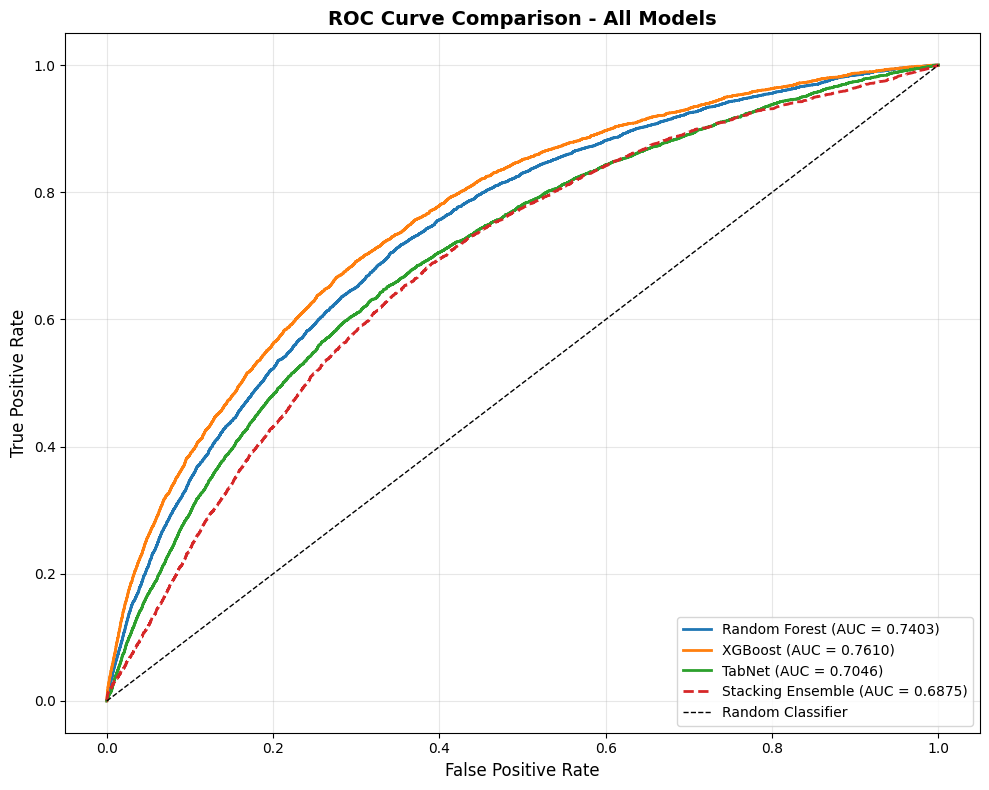

In [20]:
from sklearn.metrics import roc_curve

# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_pred_proba_rf):.4f})', linewidth=2)

# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_score(y_test, y_pred_proba_xgb):.4f})', linewidth=2)

# TabNet
fpr_tabnet, tpr_tabnet, _ = roc_curve(y_test, y_pred_proba_tabnet)
plt.plot(fpr_tabnet, tpr_tabnet, label=f'TabNet (AUC = {roc_auc_score(y_test, y_pred_proba_tabnet):.4f})', linewidth=2)

# Stacking Ensemble
fpr_stack, tpr_stack, _ = roc_curve(y_test, y_pred_proba_stack)
plt.plot(fpr_stack, tpr_stack, label=f'Stacking Ensemble (AUC = {roc_auc_score(y_test, y_pred_proba_stack):.4f})', linewidth=2, linestyle='--')

# Diagonal line
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison - All Models', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 12. Visualization - Metrics Comparison Bar Chart

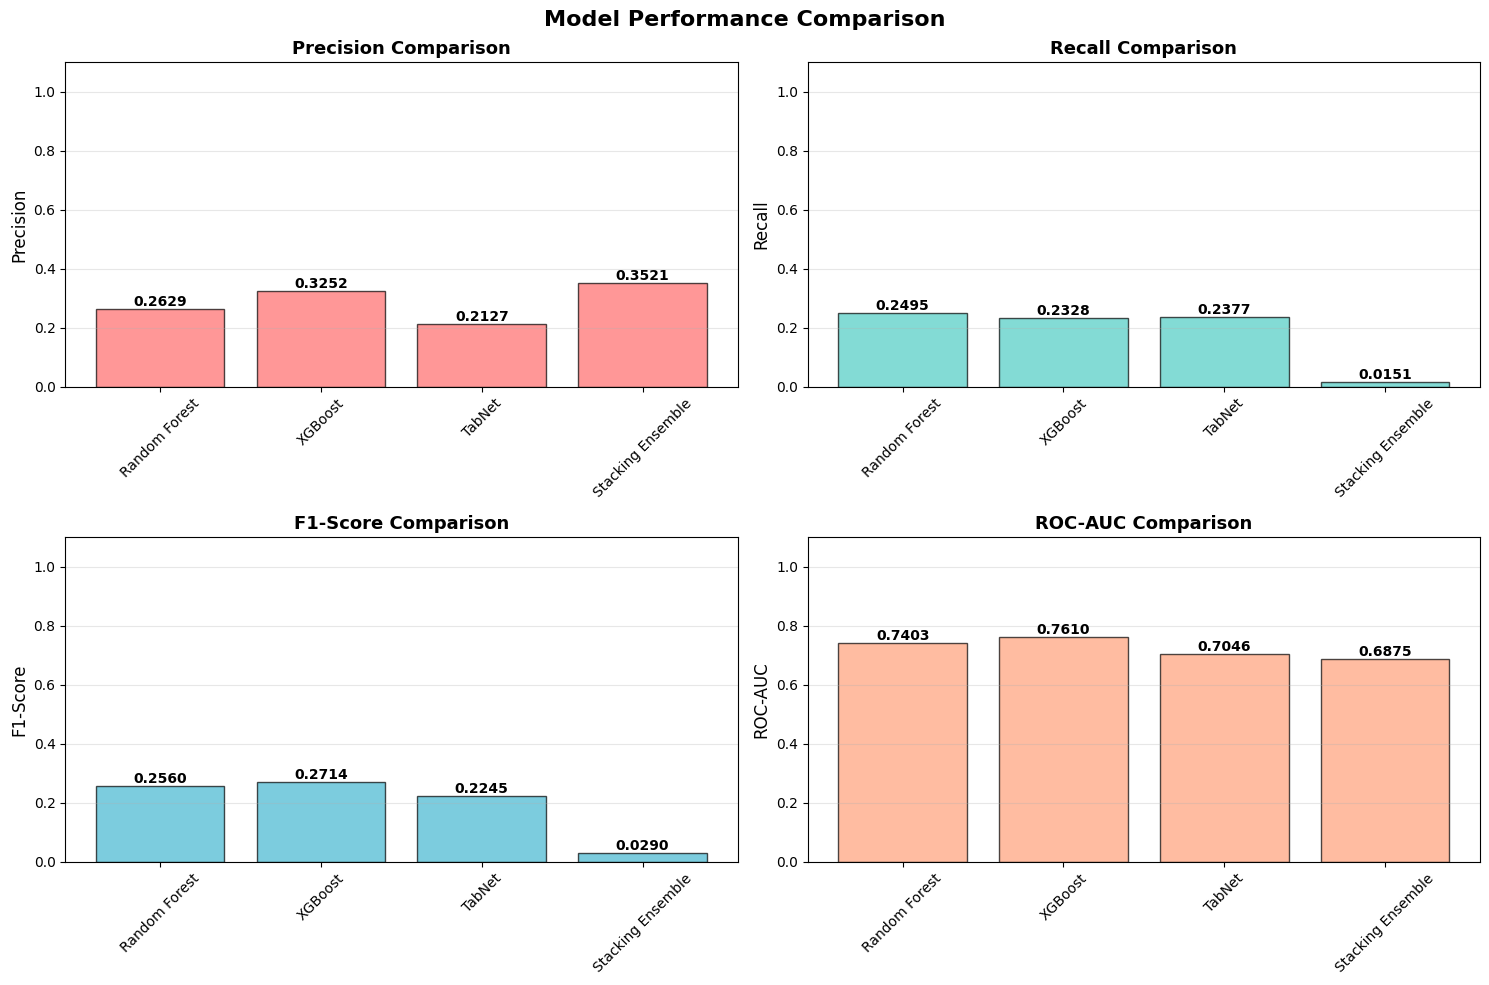

In [21]:
# Bar chart comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

metrics = ['Precision', 'Recall', 'F1-Score', 'ROC-AUC']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    bars = ax.bar(results_df['Model'], results_df[metric], color=colors[idx], alpha=0.7, edgecolor='black')

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

    ax.set_ylabel(metric, fontsize=12)
    ax.set_title(f'{metric} Comparison', fontsize=13, fontweight='bold')
    ax.set_ylim([0, 1.1])
    ax.grid(axis='y', alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 13. Feature Importance Analysis (Random Forest & XGBoost)

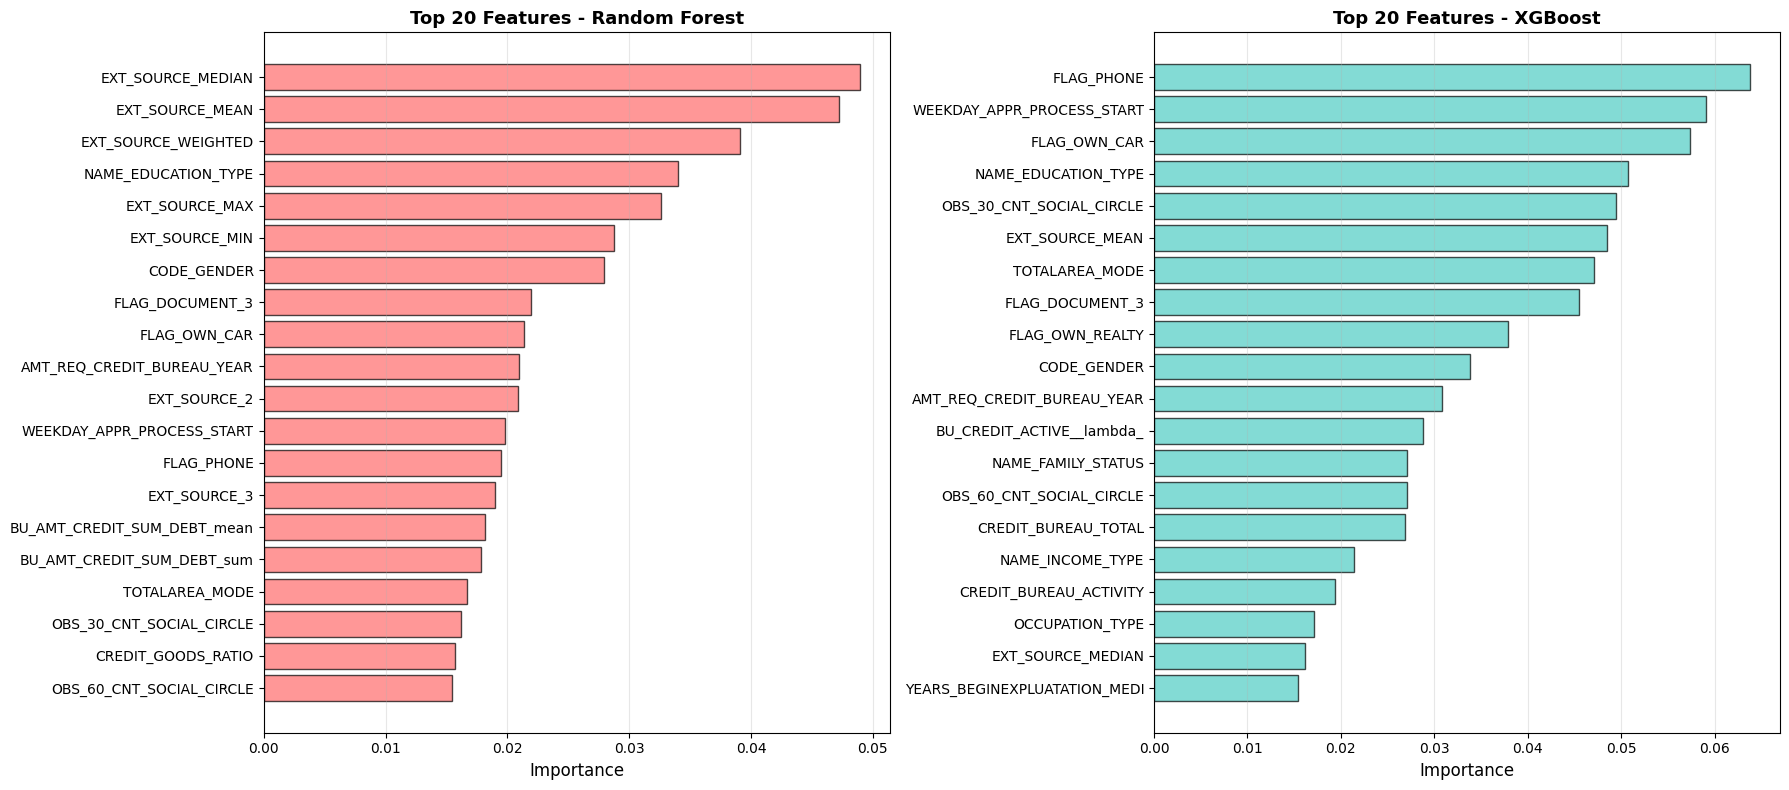

Top 10 Most Important Features (Random Forest):
                        Feature  Importance
123           EXT_SOURCE_MEDIAN    0.048936
119             EXT_SOURCE_MEAN    0.047195
124         EXT_SOURCE_WEIGHTED    0.039128
11          NAME_EDUCATION_TYPE    0.034034
120              EXT_SOURCE_MAX    0.032626
121              EXT_SOURCE_MIN    0.028789
1                   CODE_GENDER    0.027932
54              FLAG_DOCUMENT_3    0.021954
2                  FLAG_OWN_CAR    0.021400
78   AMT_REQ_CREDIT_BUREAU_YEAR    0.020922

Top 10 Most Important Features (XGBoost):
                        Feature  Importance
23                   FLAG_PHONE    0.063816
29   WEEKDAY_APPR_PROCESS_START    0.059103
2                  FLAG_OWN_CAR    0.057383
11          NAME_EDUCATION_TYPE    0.050717
48     OBS_30_CNT_SOCIAL_CIRCLE    0.049409
119             EXT_SOURCE_MEAN    0.048447
46               TOTALAREA_MODE    0.047083
54              FLAG_DOCUMENT_3    0.045461
3               FLAG_OWN_REAL

In [22]:
# Get feature importances
feature_names = X_train.columns

# Random Forest Feature Importance
rf_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False).head(20)

# XGBoost Feature Importance
xgb_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False).head(20)

# Plot feature importance
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Random Forest
axes[0].barh(range(len(rf_importance)), rf_importance['Importance'], color='#FF6B6B', alpha=0.7, edgecolor='black')
axes[0].set_yticks(range(len(rf_importance)))
axes[0].set_yticklabels(rf_importance['Feature'])
axes[0].set_xlabel('Importance', fontsize=12)
axes[0].set_title('Top 20 Features - Random Forest', fontsize=13, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# XGBoost
axes[1].barh(range(len(xgb_importance)), xgb_importance['Importance'], color='#4ECDC4', alpha=0.7, edgecolor='black')
axes[1].set_yticks(range(len(xgb_importance)))
axes[1].set_yticklabels(xgb_importance['Feature'])
axes[1].set_xlabel('Importance', fontsize=12)
axes[1].set_title('Top 20 Features - XGBoost', fontsize=13, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("Top 10 Most Important Features (Random Forest):")
print(rf_importance.head(10))
print("\nTop 10 Most Important Features (XGBoost):")
print(xgb_importance.head(10))

## 14. Save Models & Results

In [27]:
import pickle
import os

# Save Random Forest
with open('/content/models/random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

# Save XGBoost
with open('/content/models/xgboost_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

# Save TabNet
tabnet_model.save_model('/content/models/tabnet_model')

# Save Scaler
with open('/content/models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save Meta-model
with open('/content/models/meta_model.pkl', 'wb') as f:
    pickle.dump(meta_model, f)

# Save results to CSV
results_df.to_csv('/content/models/model_comparison_results.csv', index=False)
print("Results saved to '/models/model_comparison_results.csv'")

# Save feature importance
rf_importance.to_csv('/content/models/rf_feature_importance.csv', index=False)
xgb_importance.to_csv('/content/models/xgb_feature_importance.csv', index=False)

Successfully saved model at /content/models/tabnet_model.zip
Results saved to '/models/model_comparison_results.csv'
